# SETUP

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

# For time stamps
from datetime import datetime


from pathlib import Path
from warnings import simplefilter
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

# LOAD DATA

In [3]:
# The tech stocks we'll use for this analysis
tech_list = ['NDAQ', 'GOOG', 'TSLA', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['NDAQ', 'GOOG', 'TSLA', 'AMZN']

start = '2010-01-01'
end = '2022-10-30'

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

company_list = [AAPL, GOOG, TSLA, AMZN]
company_name = ["NASDAQ", "GOOGLE", "TESLA", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


NameError: name 'AAPL' is not defined

# HYBRID MODEL

## Learn from the trend

In [365]:
df_tesla = df.loc[df["company_name"].isin(["TESLA"])]
df_tesla = df_tesla["Close"]
# df_tesla = df_tesla.rename(columns = {'Close': 'Close_tesla'}, inplace=True) 
df_tesla.head()
df_amazon = df.loc[df["company_name"].isin(["AMAZON"])]
df_amazon = df_amazon["Close"]
# df_amazon = df_amazon.rename(columns = {'Close': 'Close_amazon'}, inplace=True) 
df_amazon.head()
tickers = ["AMAZON", "TESLA"]
df_ta = pd.merge(df_tesla, df_amazon, right_index=True, left_index=True)
df_ta.rename(columns = {list(df_ta)[0]: 'TESLA'}, inplace = True)
df_ta.rename(columns = {list(df_ta)[1]: 'AMAZON'}, inplace = True)
# df_ta = pd.concat({'Close': df_ta}, names=[None, 'company_name'], axis=1)
df_ta.reindex(columns=tickers)
df_ta=pd.concat({'Close_price': df_ta}, names=[None, 'Companies'], axis=1)
df_ta.head()

Close_price        
Companies        TESLA  AMAZON
Date                          
2010-06-29    1.592667  5.4305
2010-06-30    1.588667  5.4630
2010-07-01    1.464000  5.5480
2010-07-02    1.280000  5.4570
2010-07-06    1.074000  5.5030

            const   trend  trend_squared   trend_cubed
Date                                                  
2010-06-29    1.0     1.0            1.0  1.000000e+00
2010-06-30    1.0     2.0            4.0  8.000000e+00
2010-07-01    1.0     3.0            9.0  2.700000e+01
2010-07-02    1.0     4.0           16.0  6.400000e+01
2010-07-06    1.0     5.0           25.0  1.250000e+02
...           ...     ...            ...           ...
2022-10-24    1.0  3103.0      9628609.0  2.987757e+10
2022-10-25    1.0  3104.0      9634816.0  2.990647e+10
2022-10-26    1.0  3105.0      9641025.0  2.993538e+10
2022-10-27    1.0  3106.0      9647236.0  2.996432e+10
2022-10-28    1.0  3107.0      9653449.0  2.999327e+10

[3107 rows x 4 columns]


/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_80750/2753399662.py:39: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_80750/2753399662.py:40: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_80750/2753399662.py:41: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)


            const   trend  trend_squared   trend_cubed
Date                                                  
2010-06-29    1.0     1.0            1.0  1.000000e+00
2010-06-30    1.0     2.0            4.0  8.000000e+00
2010-07-01    1.0     3.0            9.0  2.700000e+01
2010-07-02    1.0     4.0           16.0  6.400000e+01
2010-07-06    1.0     5.0           25.0  1.250000e+02
...           ...     ...            ...           ...
2022-01-06    1.0  2903.0      8427409.0  2.446477e+10
2022-01-07    1.0  2904.0      8433216.0  2.449006e+10
2022-01-10    1.0  2905.0      8439025.0  2.451537e+10
2022-01-11    1.0  2906.0      8444836.0  2.454069e+10
2022-01-12    1.0  2907.0      8450649.0  2.456604e+10

[2907 rows x 4 columns]


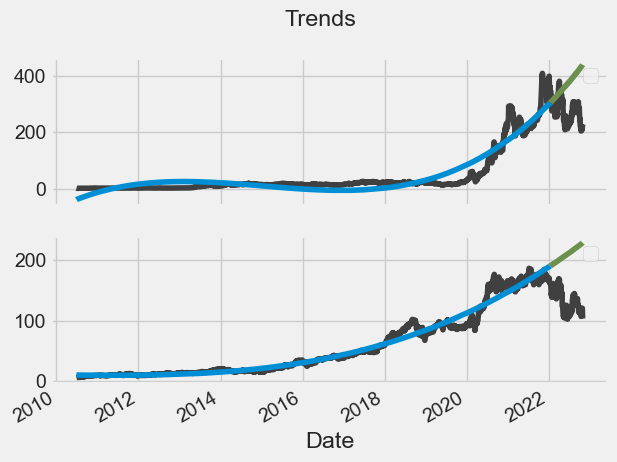

In [366]:
y = df_ta.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=3,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
print(dp)
X = dp.in_sample()  # features for the training data
print(X)
# Test on the years 2016-2020. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=200, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")
print(X_train)

## Learn from the residual

In [367]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = df_ta.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Close_price')  # grab target series
display(y)

Close_price
Date       Companies             
2010-06-29 TESLA         1.592667
           AMAZON        5.430500
2010-06-30 TESLA         1.588667
           AMAZON        5.463000
2010-07-01 TESLA         1.464000

Date        Companies
2010-06-29  TESLA          1.592667
            AMAZON         5.430500
2010-06-30  TESLA          1.588667
            AMAZON         5.463000
2010-07-01  TESLA          1.464000
                            ...    
2022-10-26  AMAZON       115.660004
2022-10-27  TESLA        225.089996
            AMAZON       110.959999
2022-10-28  TESLA        228.520004
            AMAZON       103.410004
Name: Close_price, Length: 6214, dtype: float64

In [368]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Companies')
# print(X)
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Days"] = X.index.day_of_year # values are 1, 2, ..., 12
# print(X)
# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

print(X_train)
print(y_train)

            Companies  Days
Date                       
2010-06-29          0   180
2010-06-29          1   180
2010-06-30          0   181
2010-06-30          1   181
2010-07-01          0   182
...               ...   ...
2022-01-10          1    10
2022-01-11          0    11
2022-01-11          1    11
2022-01-12          0    12
2022-01-12          1    12

[5814 rows x 2 columns]
Date        Companies
2010-06-29  TESLA          1.592667
            AMAZON         5.430500
2010-06-30  TESLA          1.588667
            AMAZON         5.463000
2010-07-01  TESLA          1.464000
                            ...    
2022-01-10  AMAZON       161.485992
2022-01-11  TESLA        354.799988
            AMAZON       165.362000
2022-01-12  TESLA        368.739990
            AMAZON       165.207001
Name: Close_price, Length: 5814, dtype: float64


In [369]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set
print(y_fit)
print(y_train)
# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit
print(y_resid)
# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

Date        Companies
2010-06-29  TESLA        -39.035961
            AMAZON         9.738623
2010-06-30  TESLA        -38.811373
            AMAZON         9.735532
2010-07-01  TESLA        -38.587264
                            ...    
2022-01-10  AMAZON       190.087642
2022-01-11  TESLA        304.666422
            AMAZON       190.268135
2022-01-12  TESLA        305.267215
            AMAZON       190.448747
Name: Close_price, Length: 5814, dtype: float64
Date        Companies
2010-06-29  TESLA          1.592667
            AMAZON         5.430500
2010-06-30  TESLA          1.588667
            AMAZON         5.463000
2010-07-01  TESLA          1.464000
                            ...    
2022-01-10  AMAZON       161.485992
2022-01-11  TESLA        354.799988
            AMAZON       165.362000
2022-01-12  TESLA        368.739990
            AMAZON       165.207001
Name: Close_price, Length: 5814, dtype: float64
Date        Companies
2010-06-29  TESLA        40.628628
           

/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_80750/2752424835.py:5: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.unstack(['Companies']).plot(
/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_80750/2752424835.py:8: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit_boosted.unstack(['Companies']).plot(
/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_80750/2752424835.py:11: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred_boosted.unstack(['Companies']).plot(


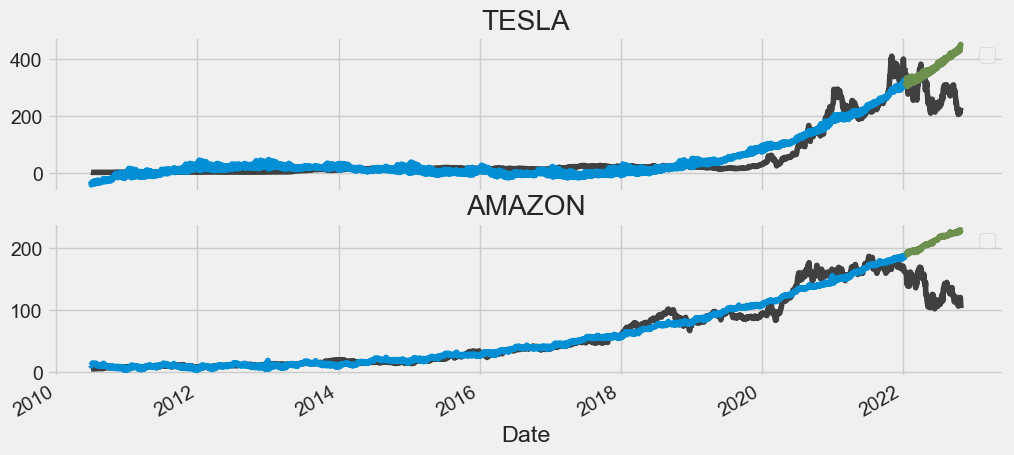

In [370]:
axs = y_train.unstack(['Companies']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['TESLA', 'AMAZON'],
)
axs = y_test.unstack(['Companies']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Companies']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Companies']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

## Add more features to the Gradient boosting (ensemble of weak predictions from decision trees)